In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

/home/ernest/anaconda3/envs/urbana/lib/python3.9/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2017
MONTH = 7

OUTPUT_WARNINGS = False
SAVE_FIGS = True
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

In [5]:
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

In [6]:
# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_GWR = DIR_MONTH / "02_gwr"

if SAVE_FIGS:
    folder_list = [
        DIR_GWR,
        DIR_GWR / "coefficients",
    ]

    import os

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [7]:
sect = pd.read_csv(
    DIR_DATA / "interim/sections_{}_{:02d}.csv".format(int(str(YEAR)[2:4]), MONTH),
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Airbnb_Location_Score     89
Airbnb_Price              55
Airbnb_Price_Person       55
Rent_Area_Flats           19
Rent_Price_Total_Flats    19
Rent_Price_Meter_Flats    19
Rent_Number_Flats         10
Nationality_USA            0
Nationality_Argentina      0
Nationality_Venezuela      0
dtype: int64

In [8]:
geo_info = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

geo_info.set_index("Tag", inplace=True)

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [9]:
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

id_max_airbnb = geo_info[VARIABLE_TO_PREDICT].idxmax()

print("Area with maximum value: " + str(id_max_airbnb))

Area with maximum value: 02_077


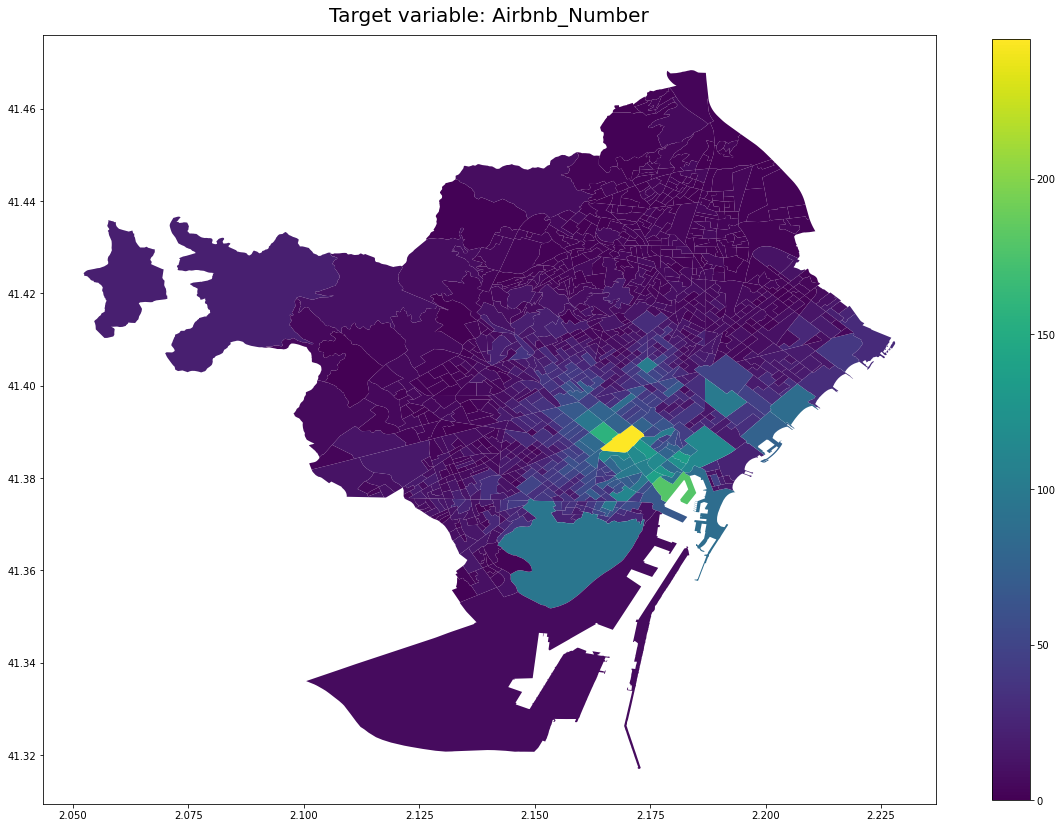

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "target_variable.svg", format="svg")

plt.show()

In [11]:
y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
    ],
    axis=1,
)
coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

In [12]:
# define the colormap
cmap = plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

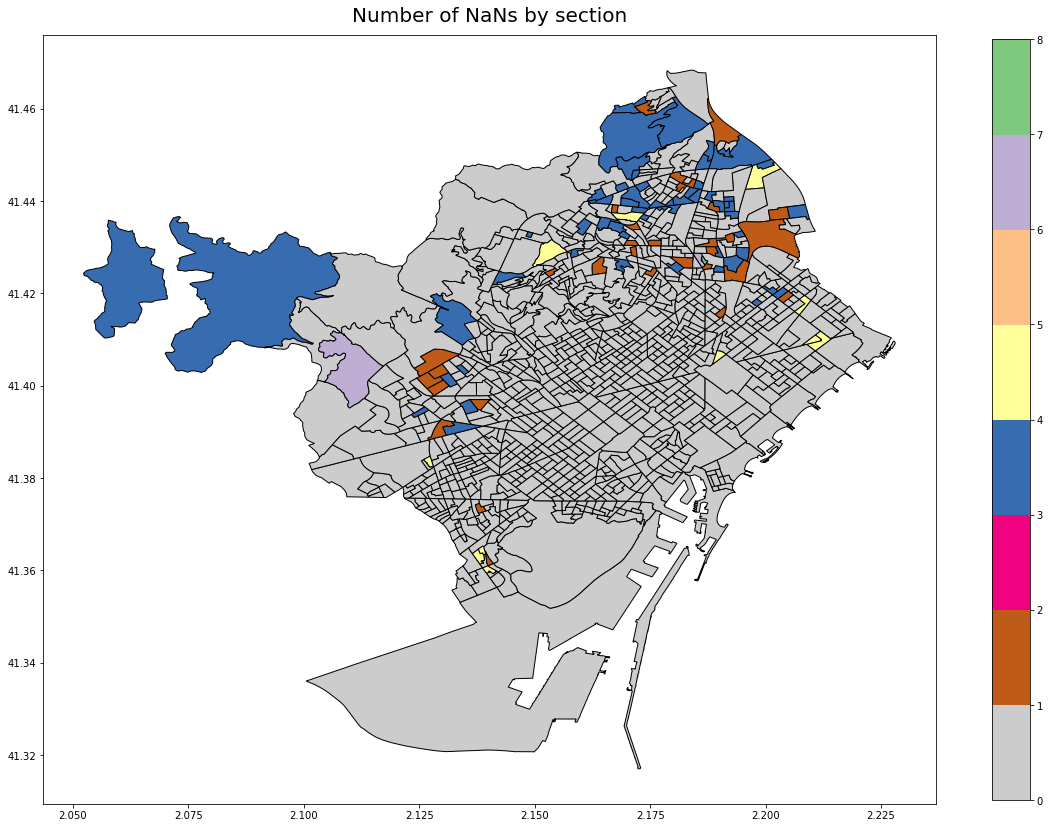

In [13]:
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "nans.svg", format="svg")

plt.show()

In [14]:
X_num = np.array(X)

# We will input the missing values with an iterative imputer
imputer = IterativeImputer()
imputer.fit(X_num)
X_num = imputer.transform(X_num)

X_std = (X_num - X_num.mean(axis=0)) / X_num.std(axis=0)
y_std = (y - y.mean(axis=0)) / y.std(axis=0)

# GWR with all the features
All of the processes being modeled operate at the same spatial scale

# GWR with chosen and transformed


We first load the best model

In [15]:
linear_coefs = pd.read_csv(DIR_MONTH / "01_linear/coefficients.csv", index_col=0)
best_model = linear_coefs.drop(["Intercept"], axis=1).columns

In [16]:
X_chosen = sect[best_model]
y_chosen = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
print(best_model)

Index(['Distance_Center', 'Nationality_UK', 'Nationality_Spain',
       'POI_Restaurants_Hotels', 'Nationality_Italy', 'Percentage_Age_65_Plus',
       'Percentage_Age_0_14', 'POI_Souvenirs_Thrift_Store'],
      dtype='object')


Let's check if there are missing values for these features

In [17]:
pd.isnull(X_chosen).sum(0)

Distance_Center               0
Nationality_UK                0
Nationality_Spain             0
POI_Restaurants_Hotels        0
Nationality_Italy             0
Percentage_Age_65_Plus        0
Percentage_Age_0_14           0
POI_Souvenirs_Thrift_Store    0
dtype: int64

Since there are not missing values, we do not have to use a imputer.

We will transform the features so they follow a Gaussain-like distribution.

In [18]:
knn_X = KNNImputer()
knn_X.fit(X_chosen)
X_transformed = knn_X.transform(X_chosen)

pw_X = PowerTransformer()
pw_X.fit(X_transformed)
X_transformed = pw_X.transform(X_transformed)

pw_y = PowerTransformer()
pw_y.fit(y_chosen)
y_transformed = pw_y.transform(y_chosen)

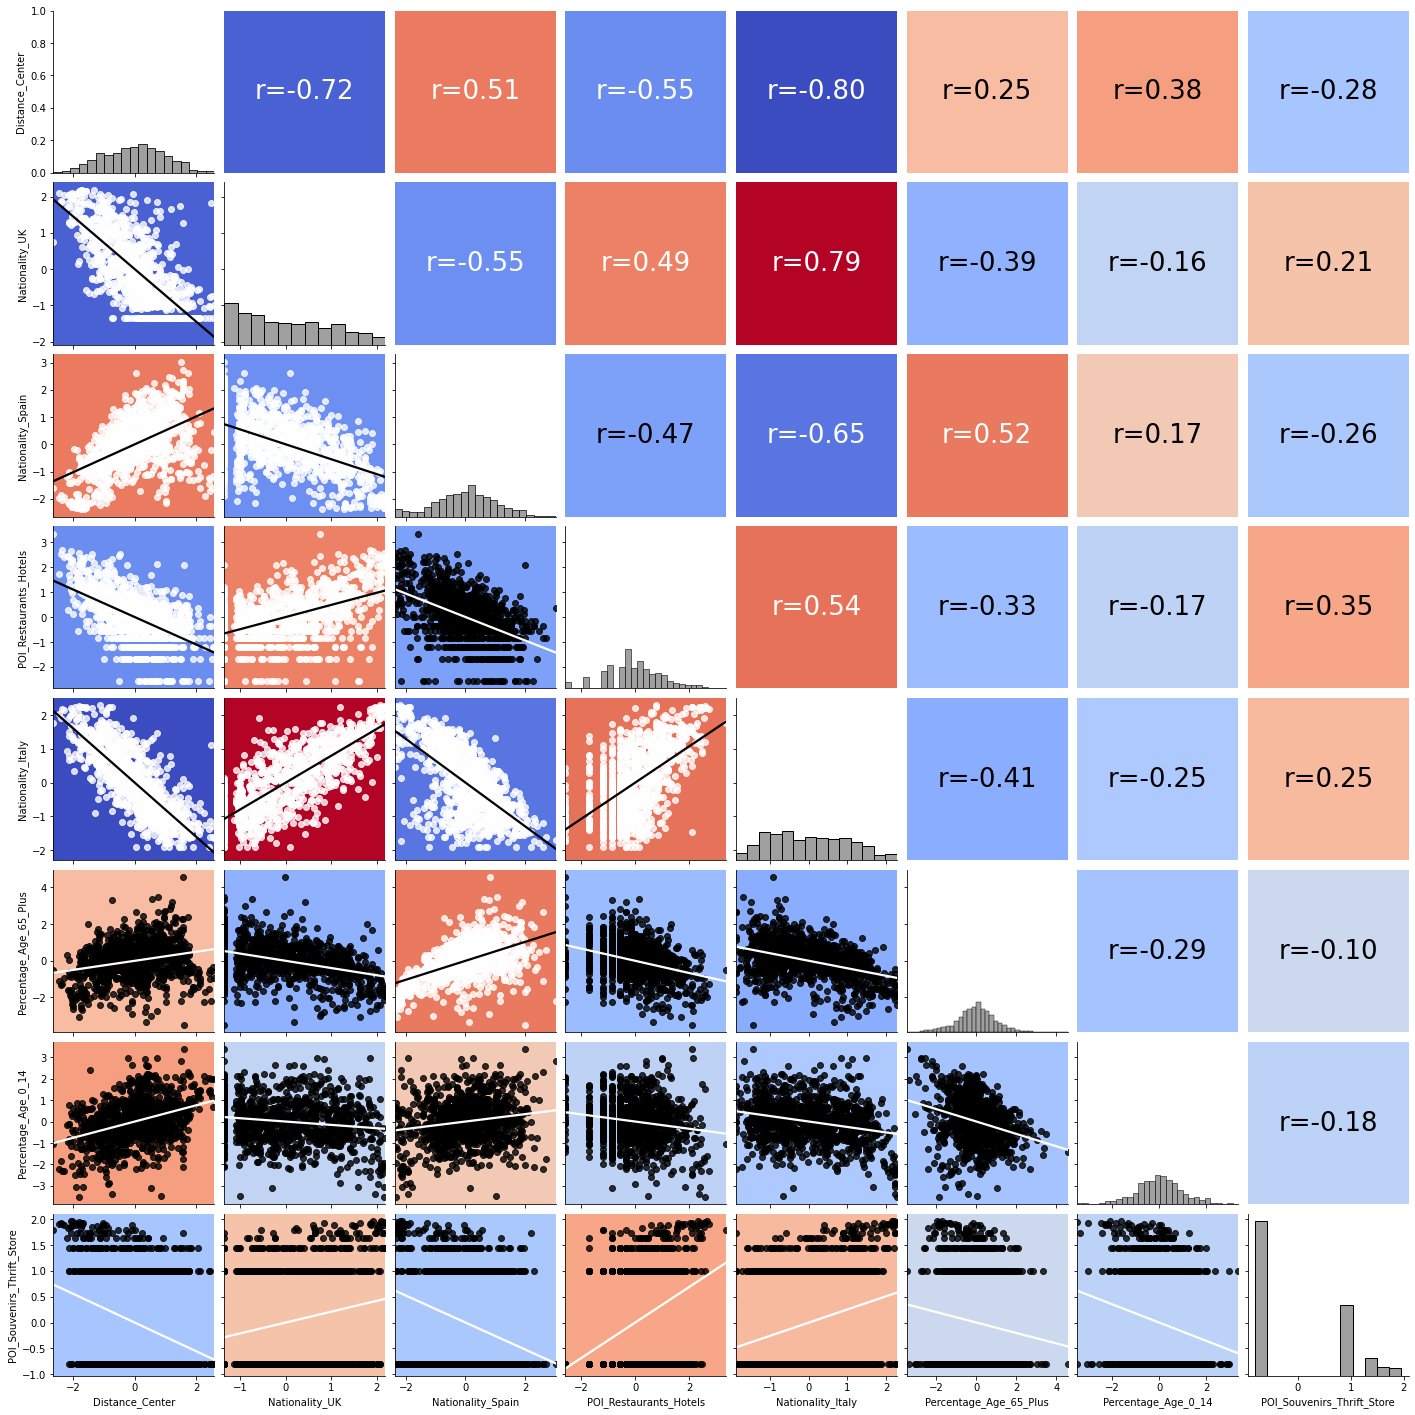

In [19]:
def corrfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    ax.annotate(
        f"r={r:.2f}",
        xy=(0.5, 0.5),
        xycoords=ax.transAxes,
        color="white" if lightness < 0.7 else "black",
        size=26,
        ha="center",
        va="center",
    )


def scattfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    myColor = "white" if lightness < 0.7 else "black"
    lineColor = "black" if lightness < 0.7 else "white"
    ax.set_facecolor(facecolor)
    sns.regplot(x, y, ax=ax, color=myColor, line_kws={"color": lineColor}, ci=None)


g = sns.PairGrid(pd.DataFrame(X_transformed, columns=X_chosen.columns))
g.map_lower(
    scattfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.map_diag(sns.histplot, color="gray", kde=False)
g.map_upper(
    corrfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.fig.subplots_adjust(wspace=0.06, hspace=0.06)  # equal spacing in both directions


if SAVE_FIGS:
    plt.savefig(DIR_GWR / "correlations.svg", format="svg")

In [20]:
vif = pd.DataFrame()
vif["VIF"] = [
    variance_inflation_factor(X_transformed, i) for i in range(X_transformed.shape[1])
]
vif["variable"] = X_chosen.columns

vif

VIF                    variable
0  3.506070             Distance_Center
1  3.000447              Nationality_UK
2  2.122258           Nationality_Spain
3  1.666308      POI_Restaurants_Hotels
4  4.514579           Nationality_Italy
5  1.838300      Percentage_Age_65_Plus
6  1.524617         Percentage_Age_0_14
7  1.170663  POI_Souvenirs_Thrift_Store

Now select the best k for the nearest neighbours bandwith.

In [21]:
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_transformed, fixed=False, spherical=True, multi=False
)
gwr_bw = gwr_chosen_selector.search()
print("GWR with chosen and transformed features")
print("Bandwith (KNN): " + str(int(gwr_bw)))

GWR with chosen and transformed features
Bandwith (KNN): 232


Fit the model

In [22]:
gwr_model = mgwr.gwr.GWR(
    coords, y_transformed, X_transformed, gwr_bw, constant=FIT_INTERCEPT
)
gwr_results = gwr_model.fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1068
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            264.105
Log-likelihood:                                                    -769.324
AIC:                                                               1556.648
AICc:                                                              1558.856
BIC:                                                              -7120.877
R2:                                                                   0.753
Adj. R2:                                                              0.751

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [23]:
gwr_model.predict(coords, X_transformed)
y_predicted = gwr_results.predictions

In [24]:
y_predicted_transformed = y_predicted.copy()
y_predicted = pw_y.inverse_transform(y_predicted).round().flatten()
y_predicted = pd.Series(y_predicted, name="GWR")
y_truth = pd.Series(y.flatten(), name="True Data")
pa_gwr = PredictedAccuracy(y_truth, y_predicted)

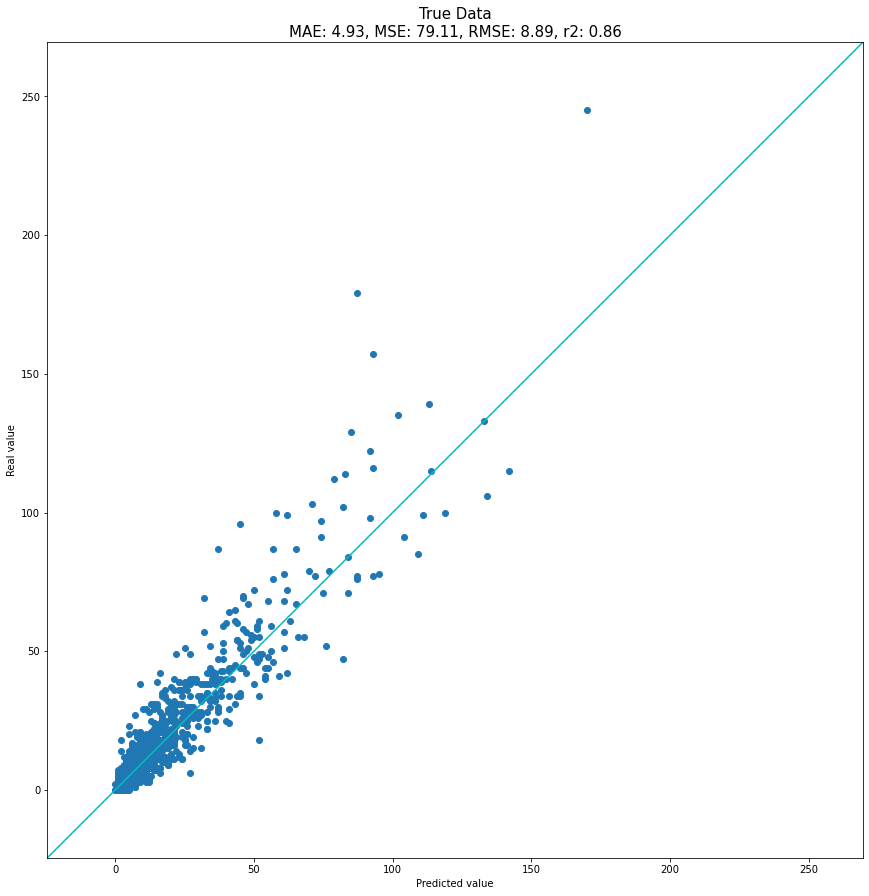

In [25]:
pa_gwr.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_GWR / "gwr_model")

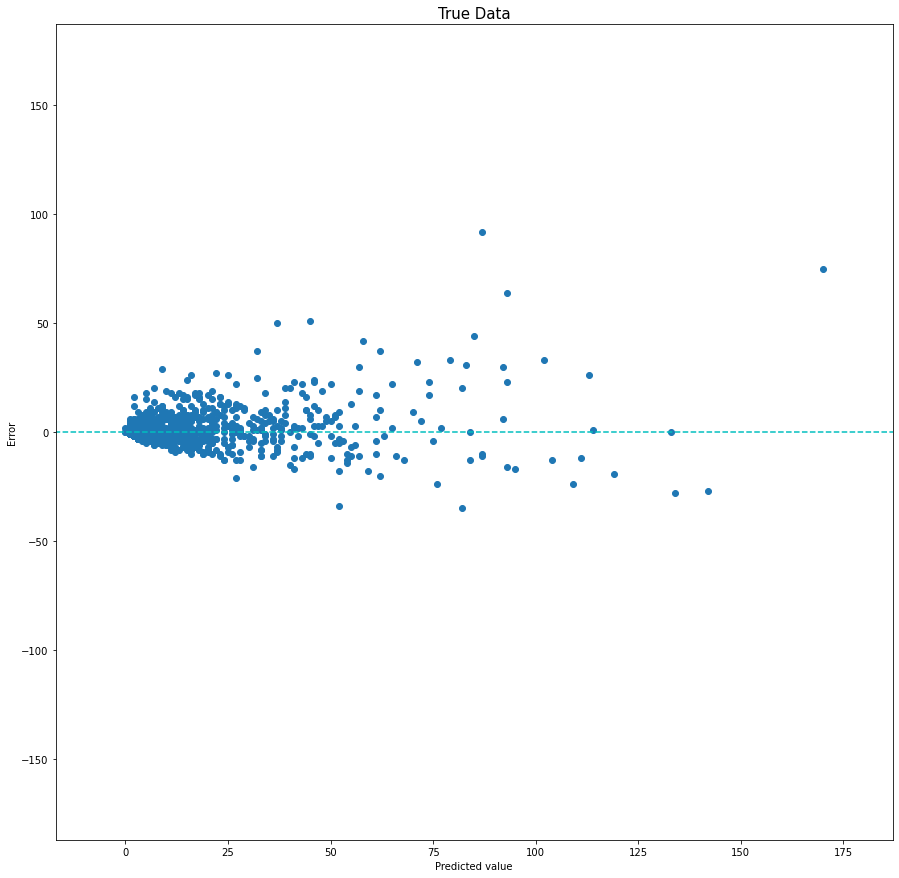

In [26]:
pa_gwr.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_GWR / "gwr_model")

In [27]:
y_predicted_transformed = pd.Series(
    y_predicted_transformed.flatten(), name="GWR_predicted_transformed"
)
y_transformed = pd.Series(y_transformed.flatten(), name="GWR_transformed")
pa_gwr_tf = PredictedAccuracy(y_transformed, y_predicted_transformed)

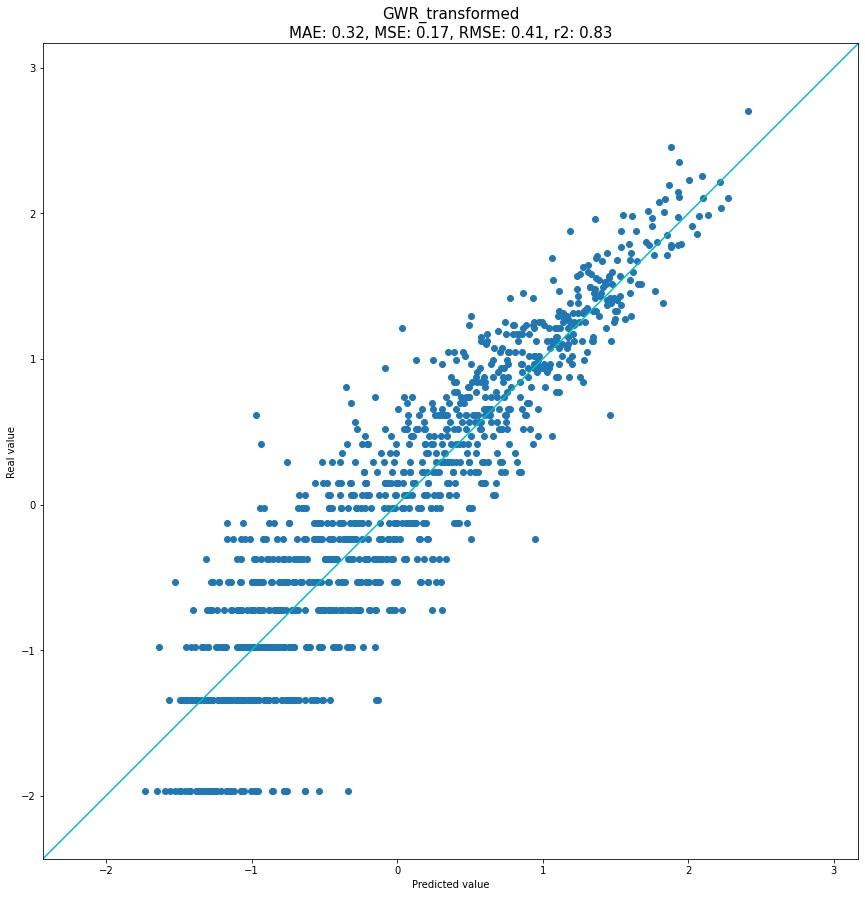

In [28]:
pa_gwr_tf.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_GWR / "gwr_transformed")

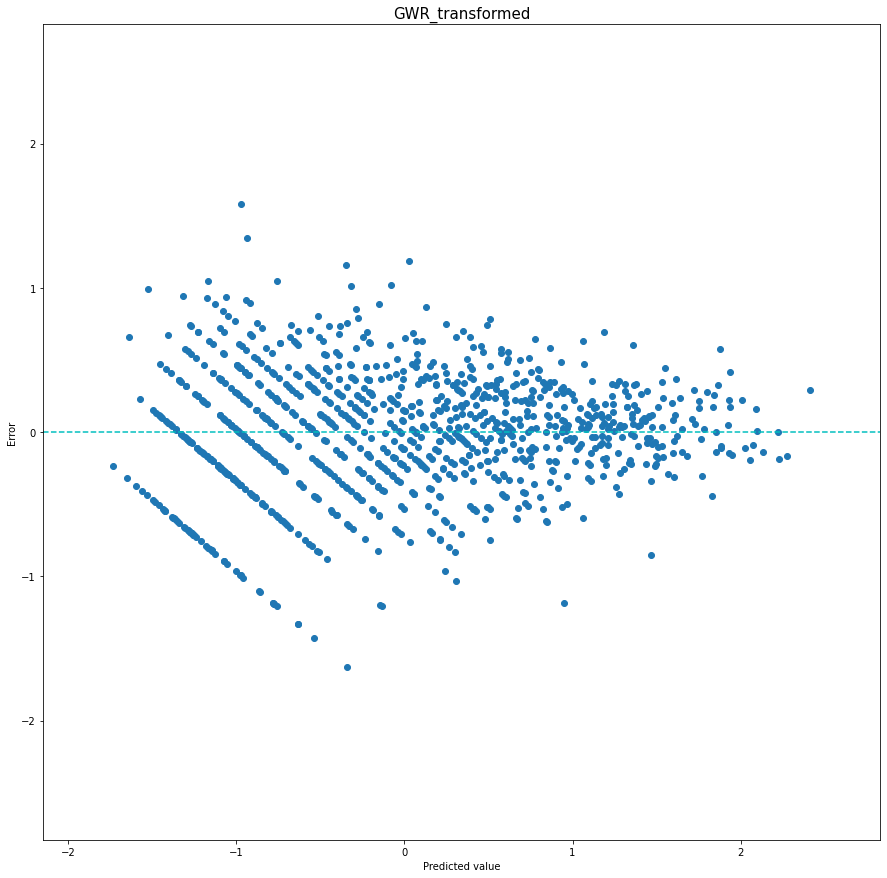

In [29]:
pa_gwr_tf.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_GWR / "gwr_transformed")

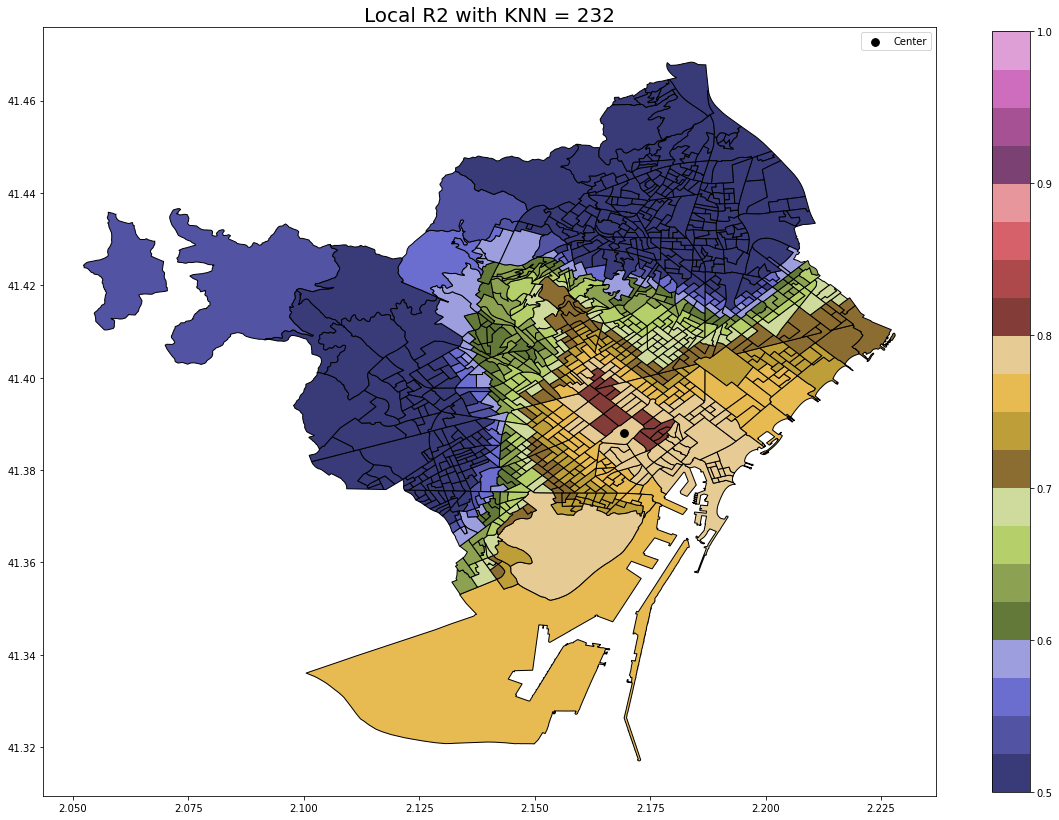

In [30]:
geo_info["Chosen_Local_R2"] = gwr_results.localR2

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Local_R2",
    legend=True,
    vmin=0.5,
    vmax=1,
    cmap="tab20b",
    legend_kwds={"shrink": 0.7},
)
geo_info[geo_info.index == id_max_airbnb].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title(
    "Local R2 with KNN = {}".format(int(gwr_bw)),
    fontsize=20,
)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "local_r2.svg", format="svg")

plt.show()

In [31]:
geo_info["Chosen_Error"] = (
    2
    * (y_truth.values - y_predicted.values)
    / (abs(y_truth.values) + abs(y_predicted.values))
)

col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

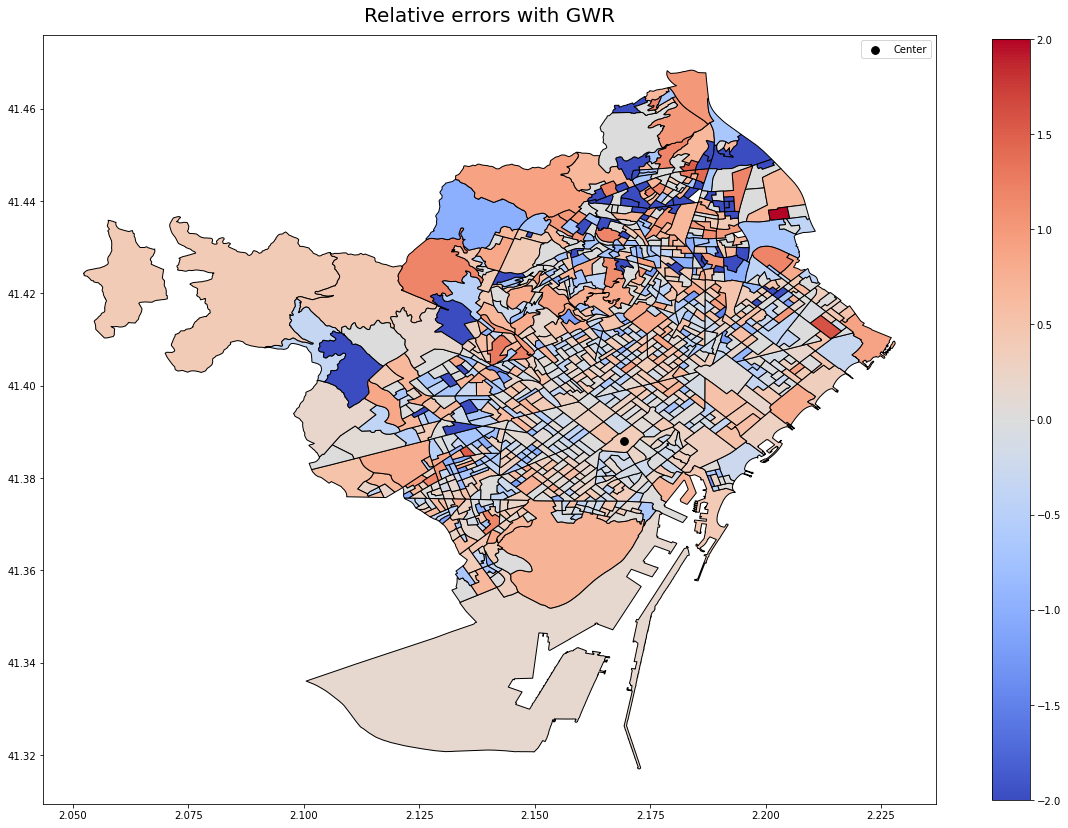

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Error",
    legend=True,
    vmin=-col_lim,
    vmax=col_lim,
    cmap="coolwarm",
    legend_kwds={"shrink": 0.7},
)

geo_info[geo_info.index == id_max_airbnb].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title("Relative errors with GWR", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "relative_errors.svg", format="svg")

plt.show()

In [33]:
gwr_columns = best_model.copy()
if FIT_INTERCEPT:
    gwr_columns = gwr_columns.insert(0, "Intercept")
coefs_gwr = pd.DataFrame(gwr_results.params, columns=gwr_columns)

medians_gwr = coefs_gwr.median()
medians_gwr = medians_gwr.reindex(medians_gwr.abs().sort_values(ascending=False).index)
coefs_gwr = coefs_gwr[medians_gwr.index]

limit_value = (
    max(abs(coefs_gwr.to_numpy().min()), abs(coefs_gwr.to_numpy().max())) * 1.05
)

In [34]:
# Copy coefficients in geodatagrame to plot
for col in coefs_gwr.columns:
    #     if col != "Intercept":
    if True:
        geo_coefs[col] = coefs_gwr[col].values

In [35]:
# Get t-vals of coefficientes
gwr_filtered_t = pd.DataFrame(gwr_results.filter_tvals(), columns=gwr_columns)
gwr_filtered_t.index = geo_info.index

In [36]:
# Copy coefficients in new dataframe so non-significant can later be removed
geo_significant_coefs = geo_coefs.copy()

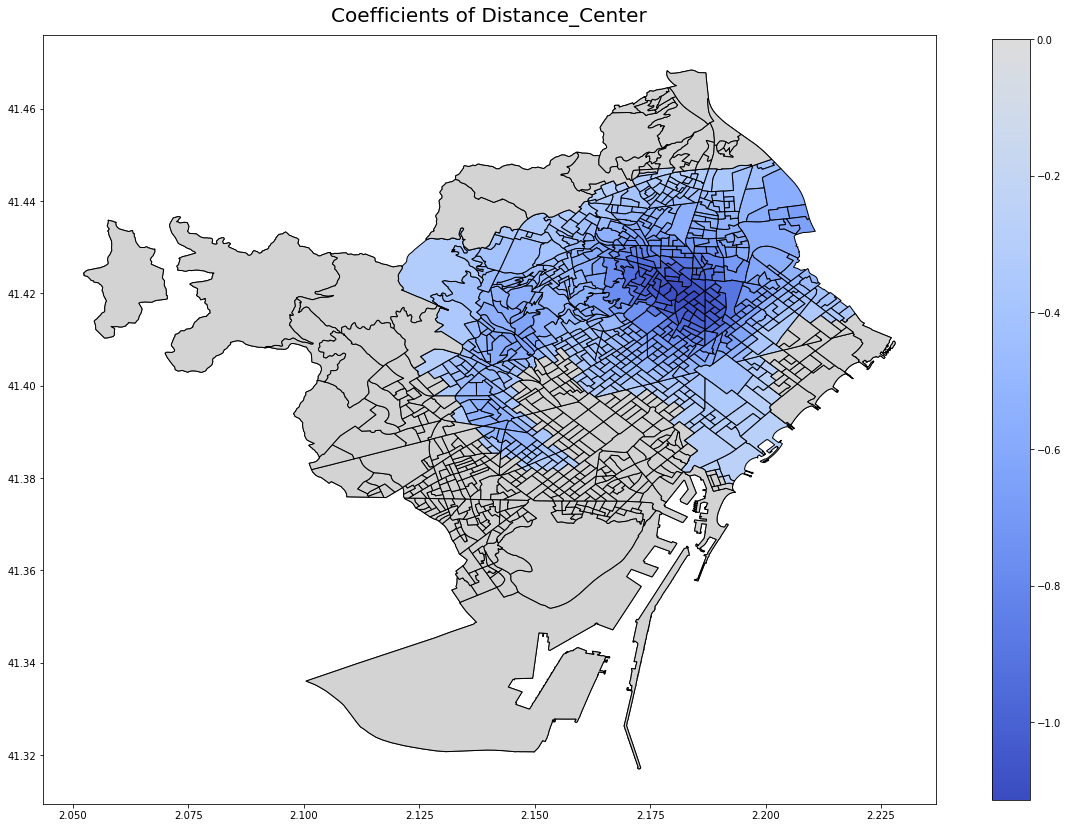

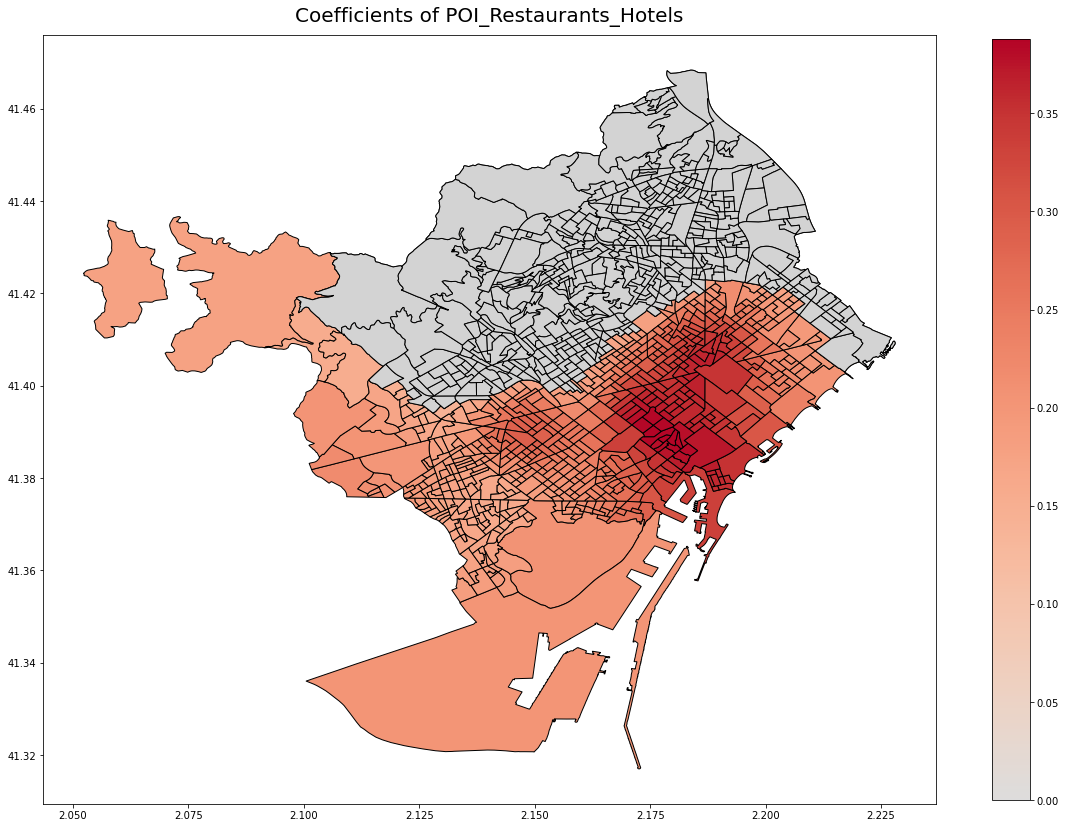

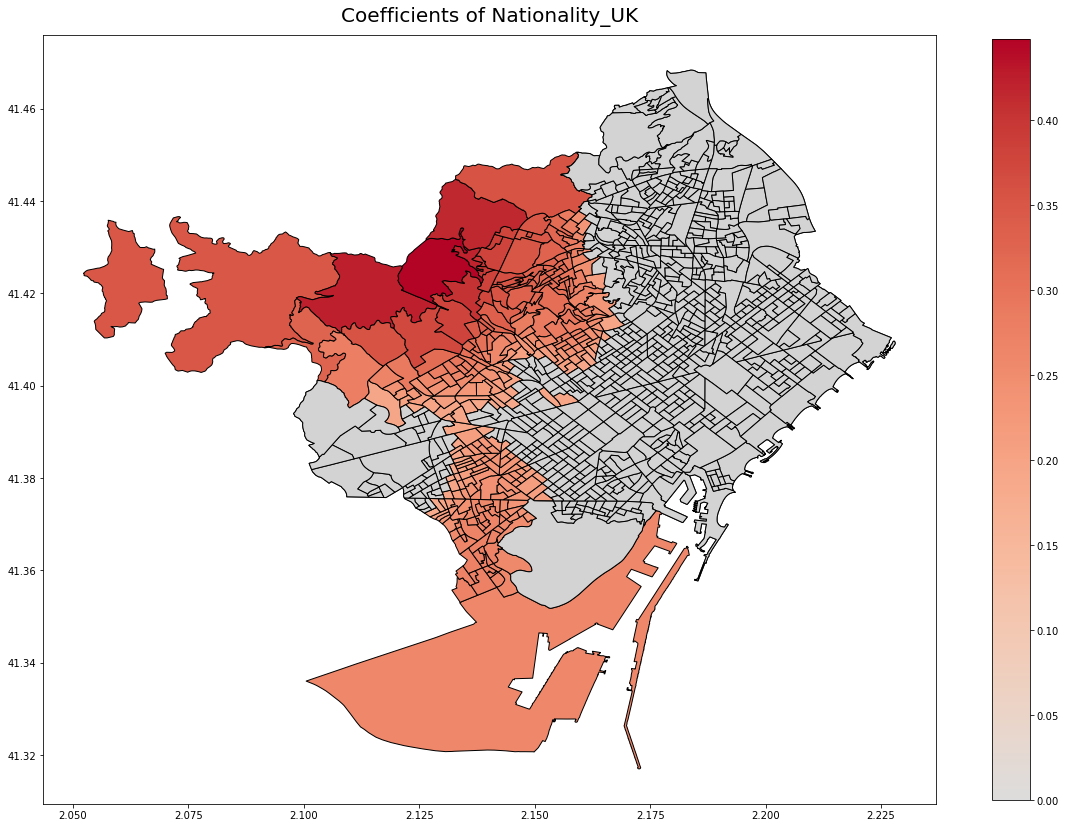

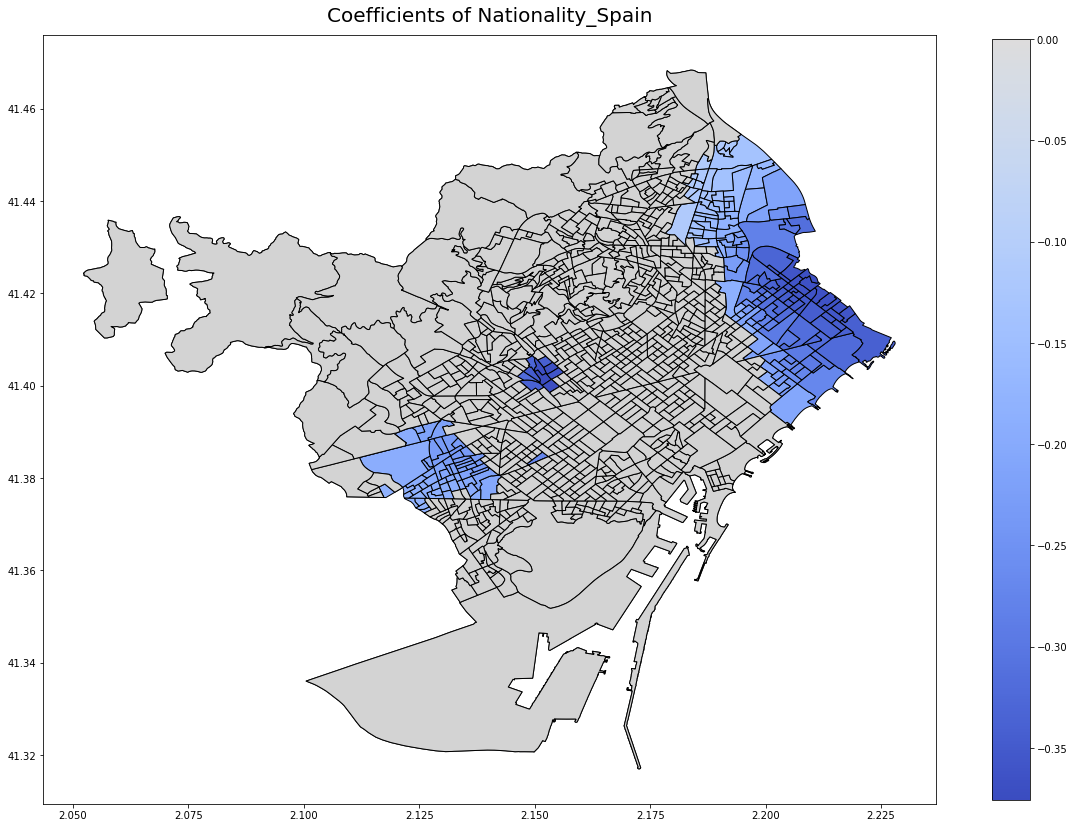

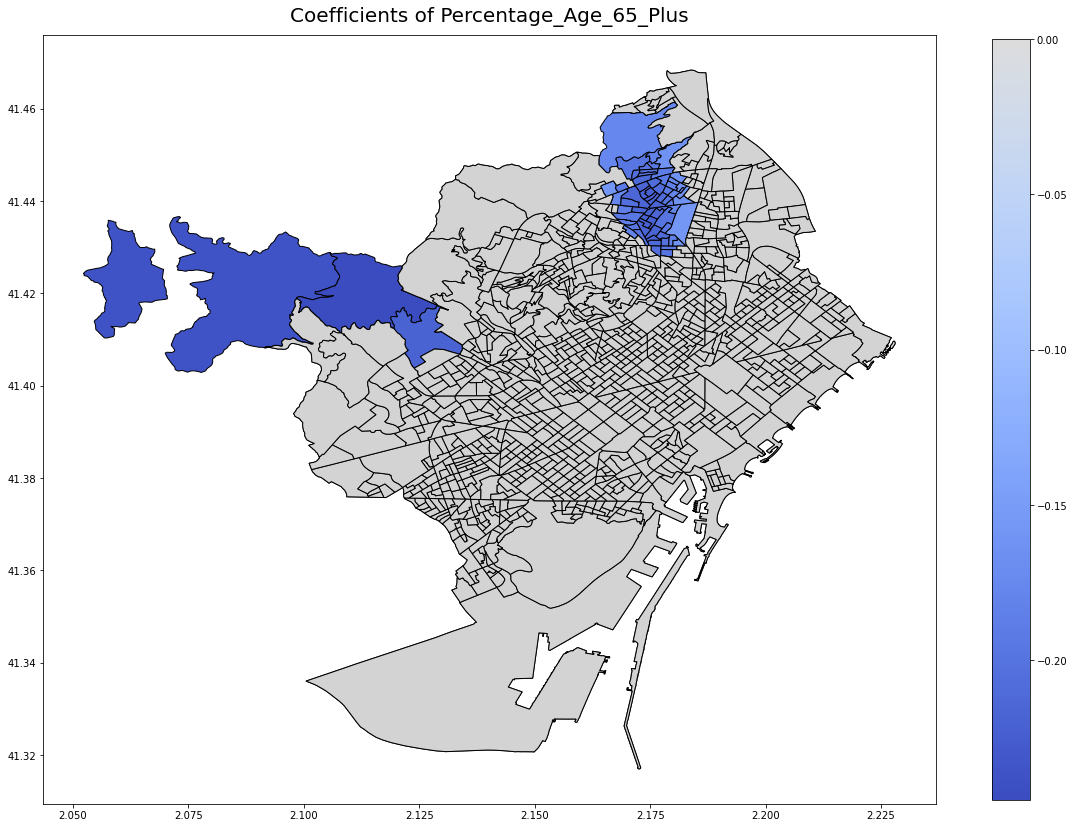

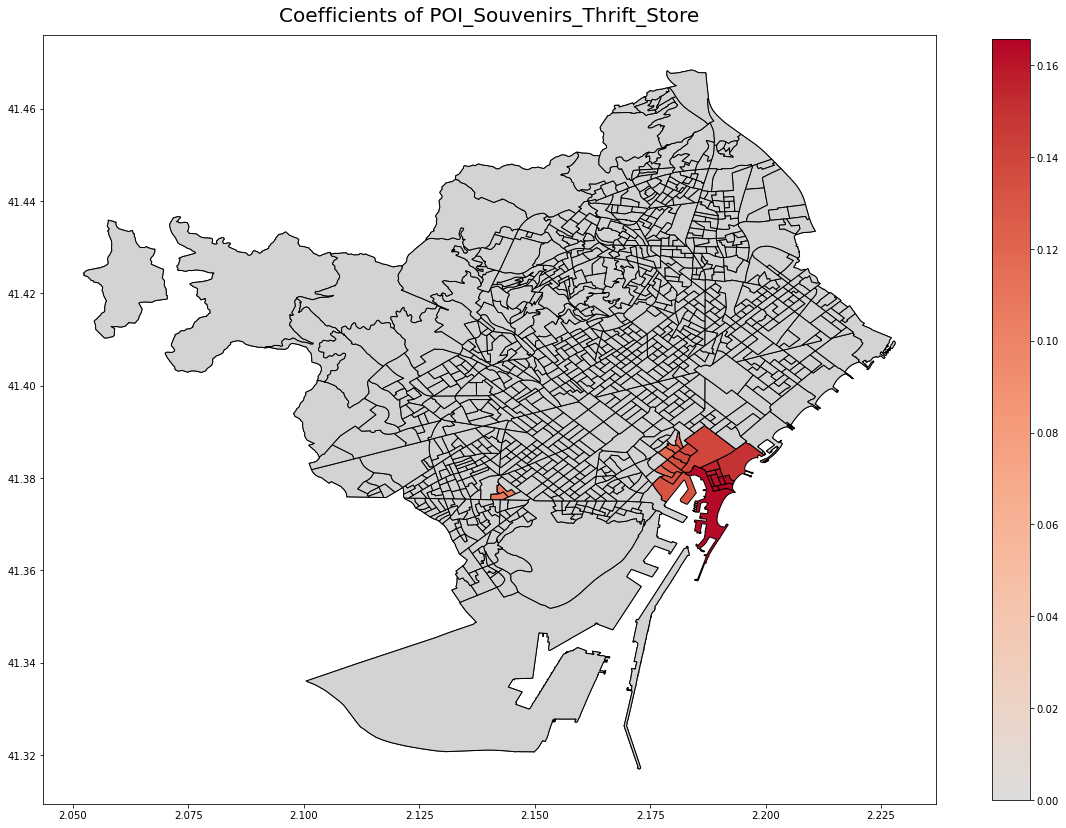

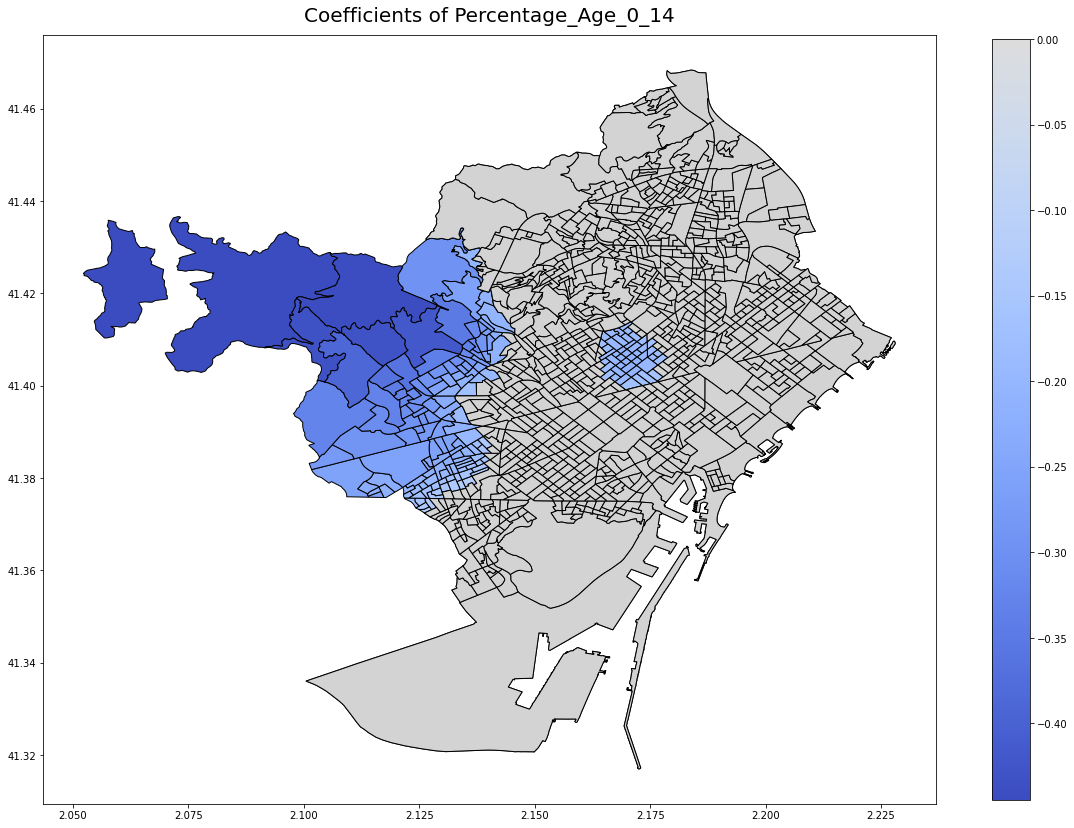

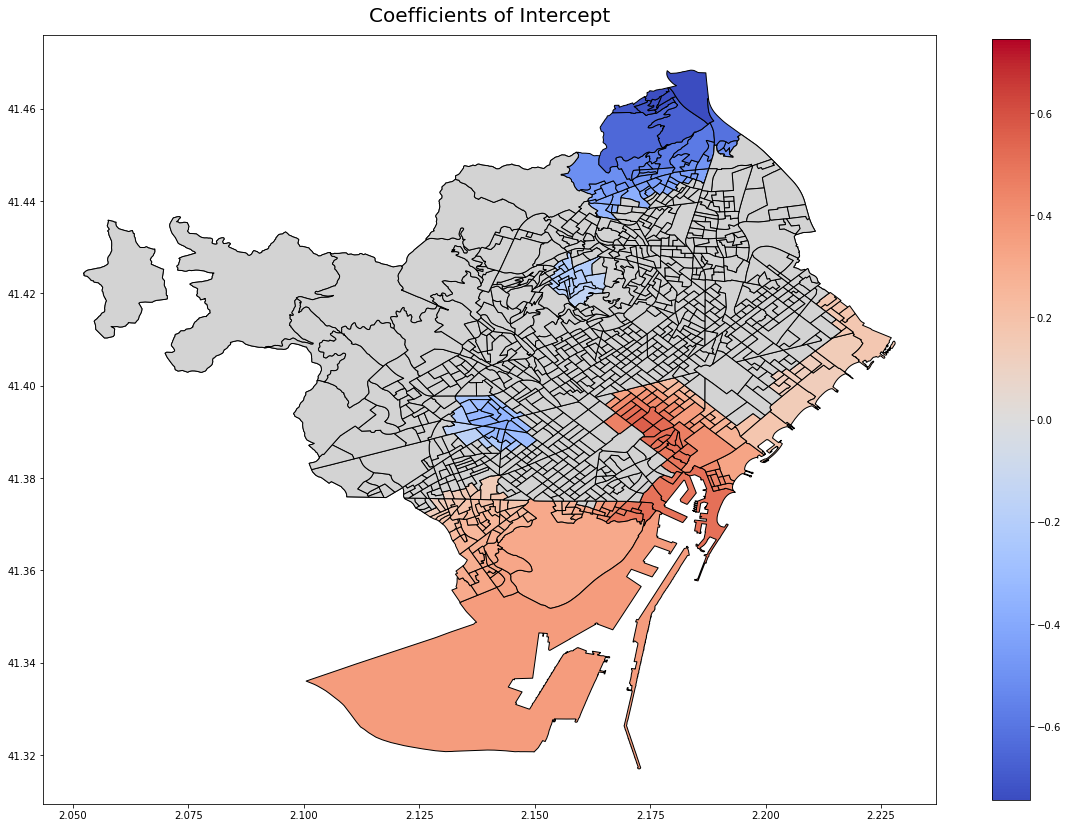

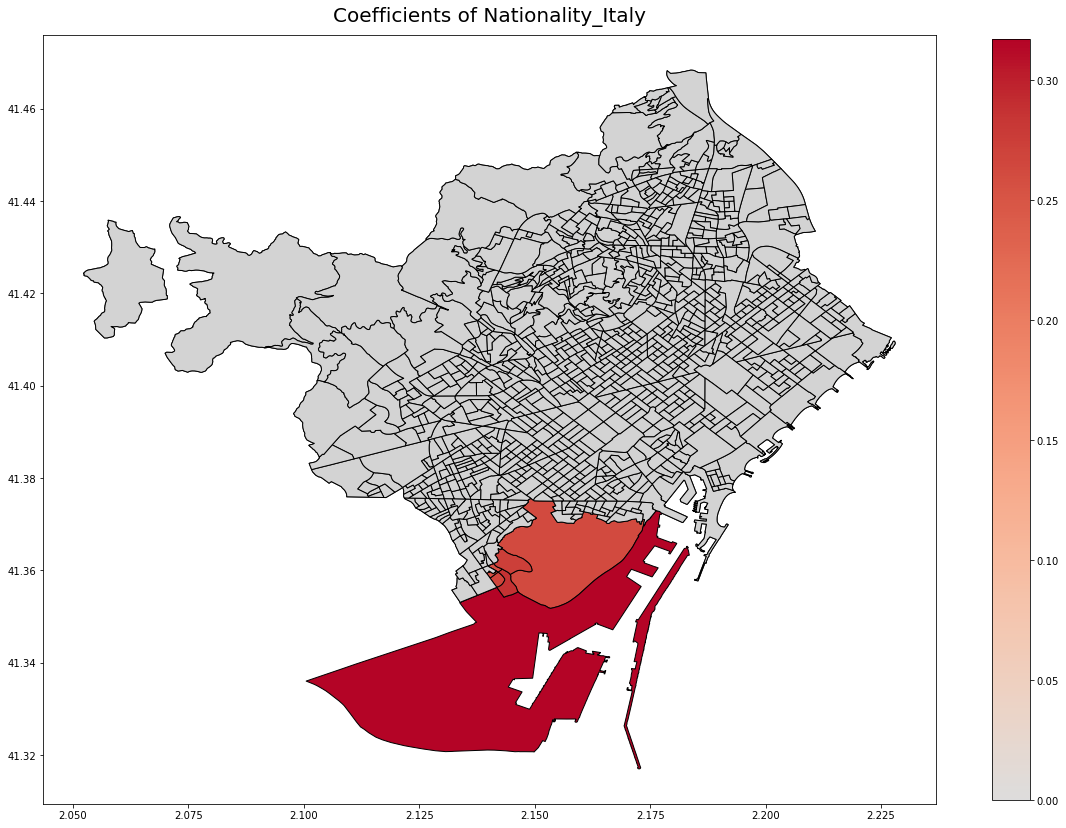

In [37]:
for col in coefs_gwr.columns:
    #     if col != "Intercept":
    if True:
        fig, ax = plt.subplots(figsize=(20, 20))
        min_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].min()
        max_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].max()

        cool_warm_cmap = plt.cm.coolwarm

        if min_coef < 0 and max_coef < 0:
            interval = np.linspace(0, 0.5)
            colors = cool_warm_cmap(interval)
            cool_warm_cmap = mpl.colors.LinearSegmentedColormap.from_list(
                "name", colors
            )
            vmin = min_coef
            vmax = 0
        elif min_coef > 0 and max_coef > 0:
            interval = np.linspace(0.5, 1)
            colors = cool_warm_cmap(interval)
            cool_warm_cmap = mpl.colors.LinearSegmentedColormap.from_list(
                "name", colors
            )
            vmin = 0
            vmax = max_coef
        else:
            vmax = max(abs(min_coef), abs(max_coef))
            vmin = -vmax

        geo_coefs.plot(
            ax=ax,
            edgecolor="black",
            column=col,
            legend=True,
            vmin=vmin,
            vmax=vmax,
            cmap=cool_warm_cmap,
            legend_kwds={"shrink": 0.7},
        )
        if (gwr_filtered_t.loc[:, col] == 0).any():
            geo_info[gwr_filtered_t.loc[:, col] == 0].plot(
                color="lightgrey", ax=ax, **{"edgecolor": "black"}
            )
            temp = geo_significant_coefs[[col]]
            temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
            geo_significant_coefs[col] = temp[col]

        ax.set_title("Coefficients of {}".format(col), fontsize=20, y=1.01)

        if SAVE_FIGS:
            plt.savefig(
                DIR_GWR / "coefficients/{}.svg".format(col),
                format="svg",
            )

        plt.show()

In [38]:
significant_coefs_gwr = geo_significant_coefs.drop(["geometry"], axis=1)

limit_value = (
    max(
        np.nanmin(abs(significant_coefs_gwr.to_numpy())),
        np.nanmax(abs(significant_coefs_gwr.to_numpy())),
    )
    * 1.05
)

if FIT_INTERCEPT:
    medians_gwr = significant_coefs_gwr.drop(["Intercept"], axis=1).median()
else:
    medians_gwr = significant_coefs_gwr.median()

medians_gwr = medians_gwr.reindex(medians_gwr.abs().sort_values(ascending=False).index)

if FIT_INTERCEPT:
    medians_gwr = medians_gwr.append(pd.Series({"Intercept": 0}, index=["Intercept"]))

significant_coefs_gwr = significant_coefs_gwr[medians_gwr.index]

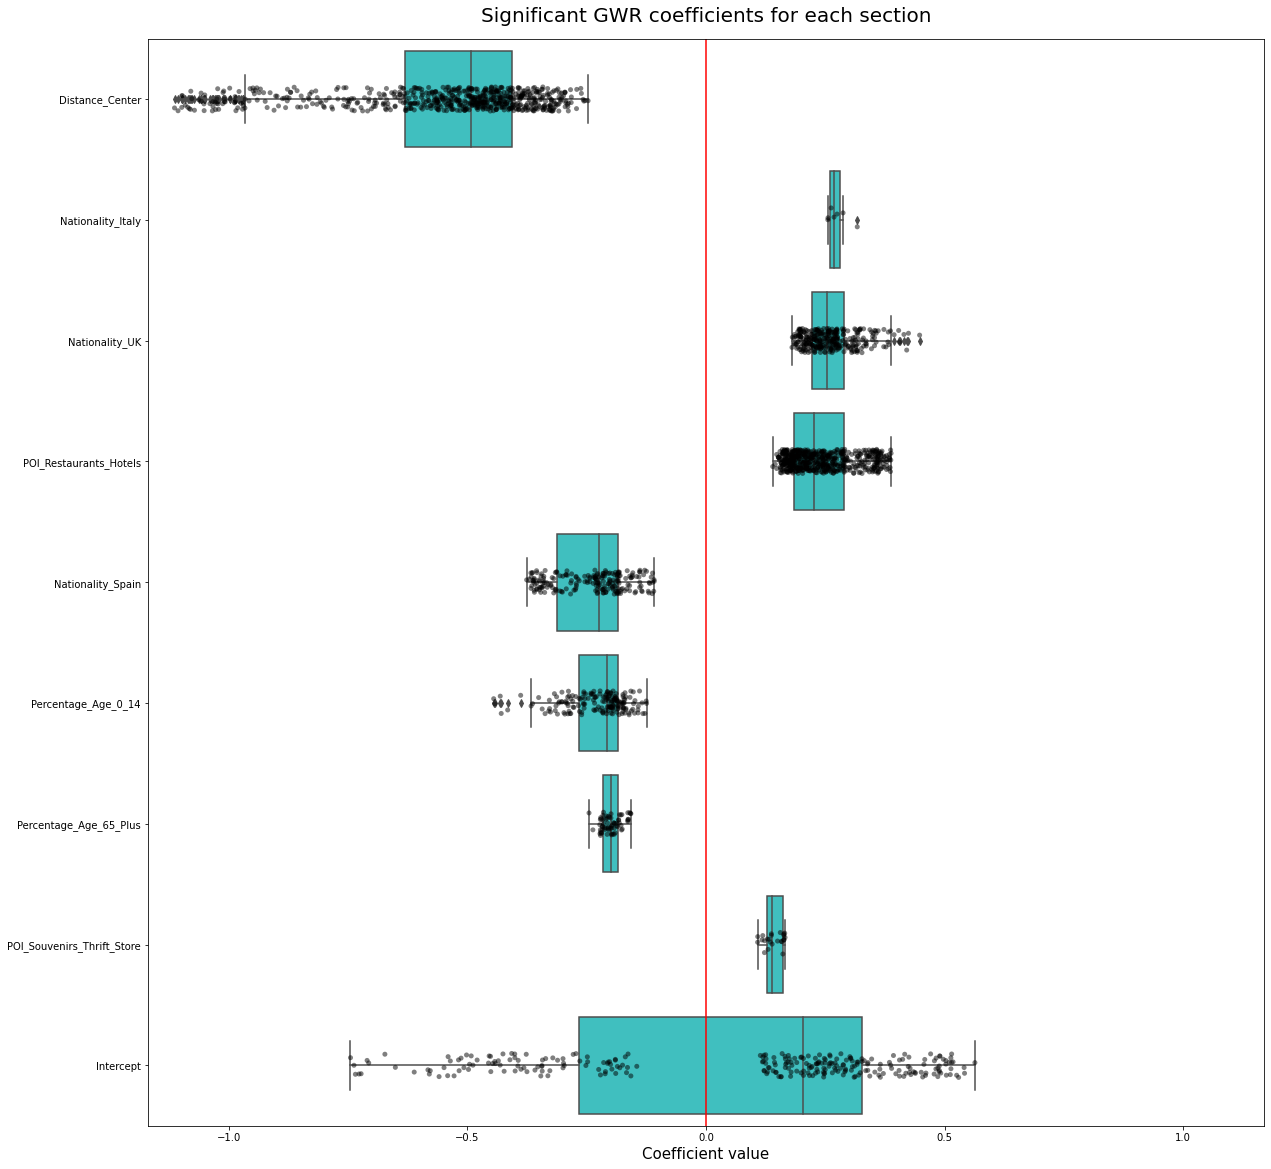

In [39]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(
    ax=ax,
    data=significant_coefs_gwr,
    orient="h",
    color="k",
    alpha=0.5,
)
sns.boxplot(
    ax=ax,
    data=significant_coefs_gwr,
    orient="h",
    color="cyan",
    saturation=0.5,
)
plt.axvline(x=0, color="red")

ax.set_title("Significant GWR coefficients for each section", fontsize=20, y=1.01)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "gwr_significant_coefficients.svg", format="svg")

plt.show()

In [40]:
significant_count = pd.DataFrame(
    [significant_coefs_gwr.count().index, significant_coefs_gwr.count().values]
).T
significant_count.columns = ["Features", "Percentage"]
significant_count["Percentage"] = significant_count["Percentage"] / X.shape[0]

significant_count.sort_values(by=["Percentage"], ascending=False, inplace=True)

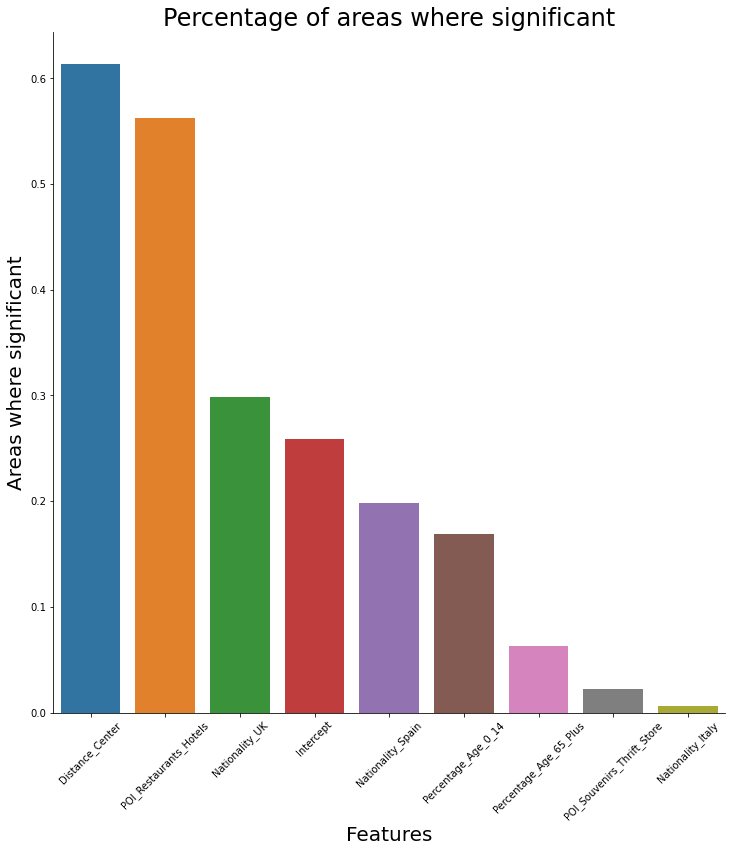

In [41]:
g = sns.catplot(
    ax=ax,
    x="Features",
    y="Percentage",
    kind="bar",
    data=significant_count,
    height=10,
    aspect=1,
)

# g.set_title("Significancy of features", fontsize=50)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Areas where significant", fontsize=20)
plt.xticks(rotation=45)
plt.title("Percentage of areas where significant", size=24)

if SAVE_FIGS:
    g.savefig(DIR_GWR / "significant_counts.svg", format="svg")

plt.show()

In [42]:
area_count = pd.DataFrame(
    [significant_coefs_gwr.index, significant_coefs_gwr.T.count().values]
).T
area_count.columns = ["Area", "Count"]
area_count.set_index("Area", inplace=True)
geo_info["Area_Count"] = area_count["Count"]

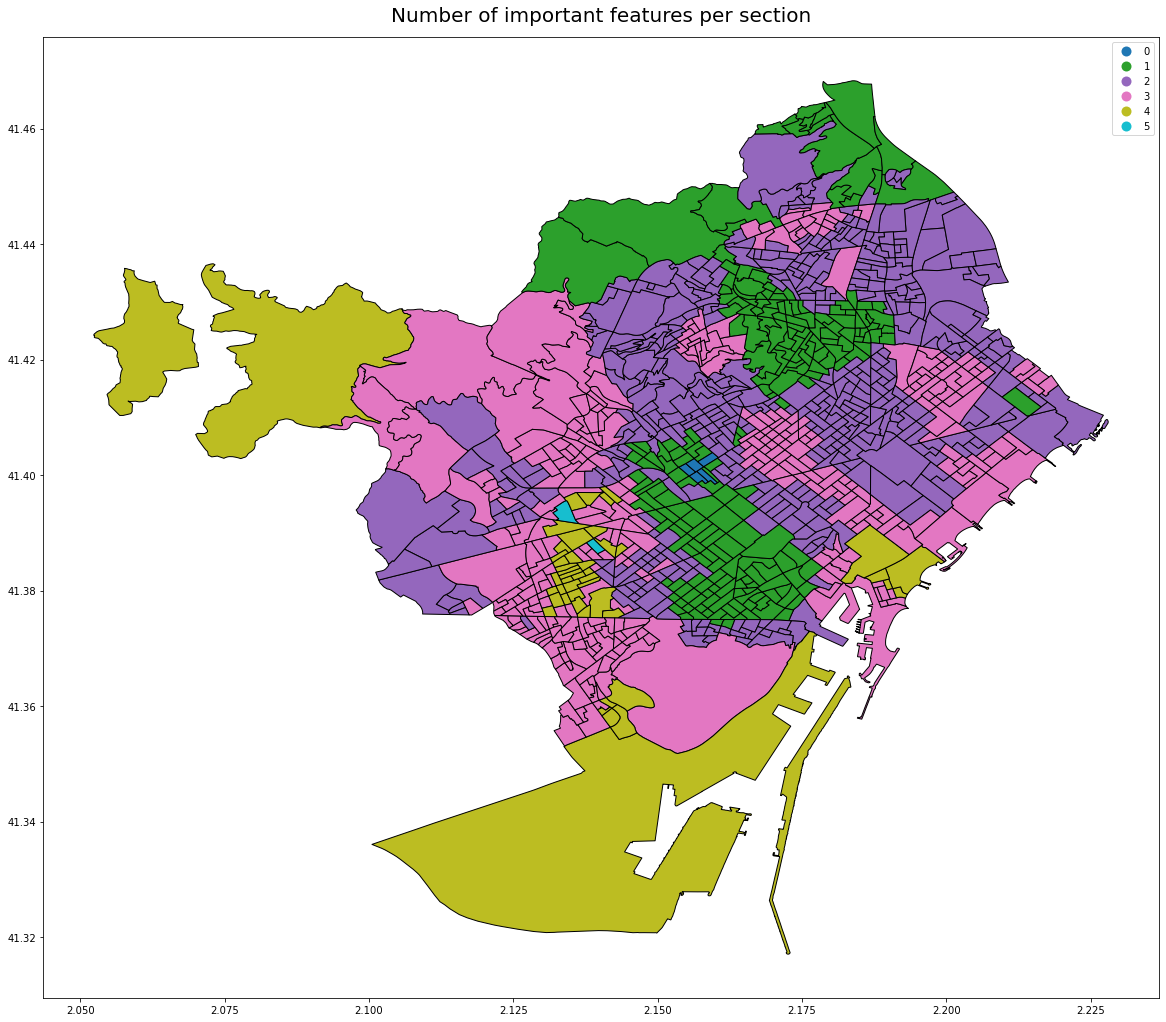

In [43]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Area_Count",
    legend=True,
    #     vmin=0.5,
    #     vmax=1,
    cmap="tab10",
    #     legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of important features per section", fontsize=20, y=1.01)

# geo_info[geo_info[VARIABLE_TO_PREDICT] == 0].centroid.plot(ax=ax, color="red")

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "number_features.svg", format="svg")

plt.show()

In [44]:
geo_info["Chosen_Most_Important"] = (
    significant_coefs_gwr.fillna(0).abs().idxmax(axis=1).values
)

temp = geo_info["Chosen_Most_Important"]
temp[significant_coefs_gwr.fillna(0).abs().max(axis=1) == 0] = "!NONE"
geo_info["Chosen_Most_Important"] = temp

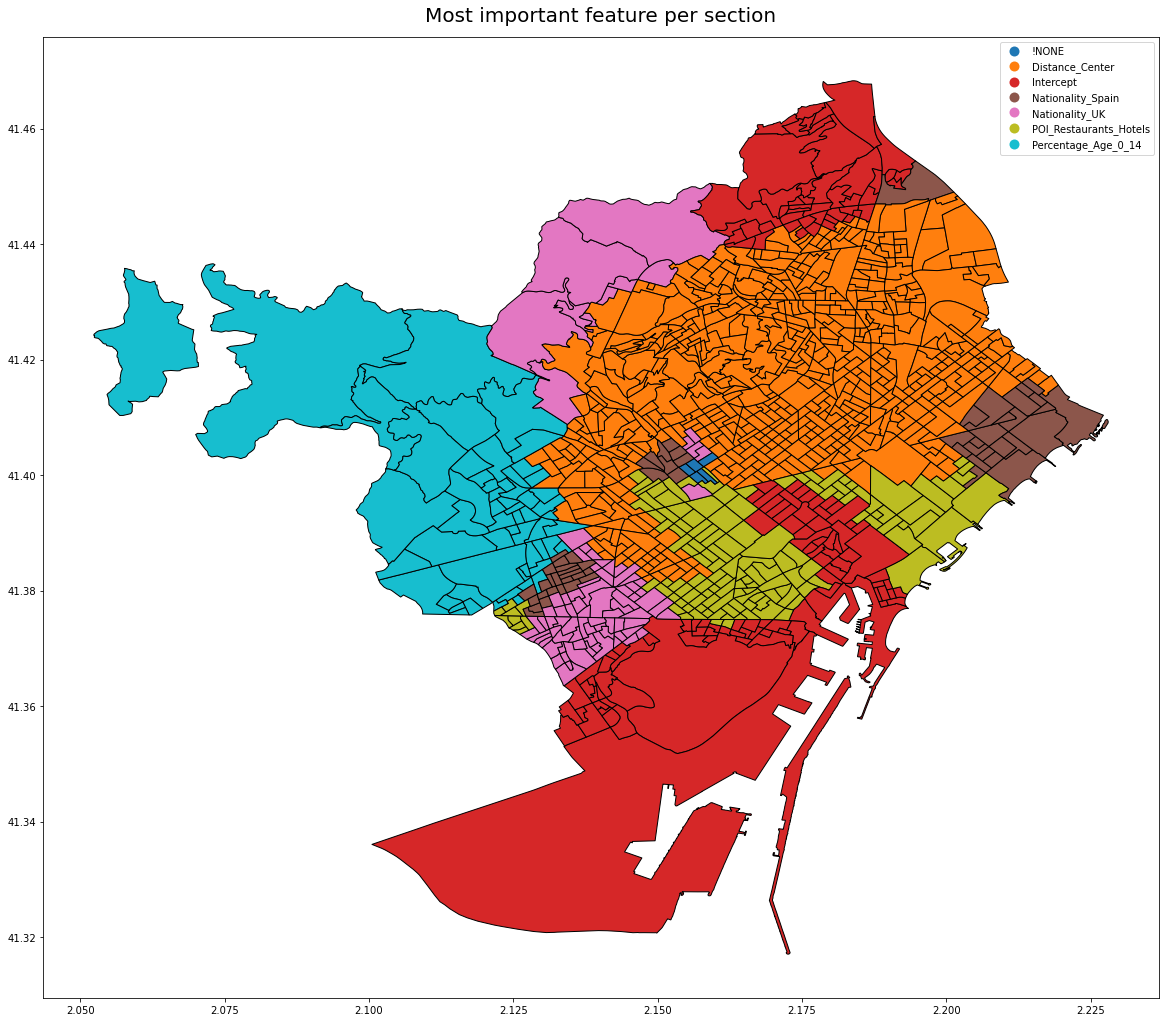

In [45]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Most_Important",
    legend=True,
)

ax.set_title("Most important feature per section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "important_features.svg", format="svg")


plt.show()

In [46]:
# from pandas.plotting import parallel_coordinates

# for i in coefs_gwr["Chosen_Most_Important"].unique():
#     plt.figure(figsize=(20, 20))
#     parallel_coordinates(
#         frame=coefs_gwr[coefs_gwr["Chosen_Most_Important"] == i].drop(
#             ["Intercept"], axis=1
#         ),
#         class_column="Chosen_Most_Important",
#         alpha=0.5,
#         colormap="Set1",
#     )

In [47]:
comparison = []
comparison_names = []
for col in significant_coefs_gwr.columns:
    comparison.append(significant_coefs_gwr[col].dropna().values)
    comparison.append(linear_coefs[col].values)
    comparison_names.append("GWR - {}".format(col))
    comparison_names.append("Linear - {}".format(col))


df_comparison = pd.DataFrame(comparison).T
df_comparison.columns = [col for col in comparison_names]

limit_value = (
    max(
        np.nanmin(abs(df_comparison.to_numpy())),
        np.nanmax(abs(df_comparison.to_numpy())),
    )
    * 1.05
)

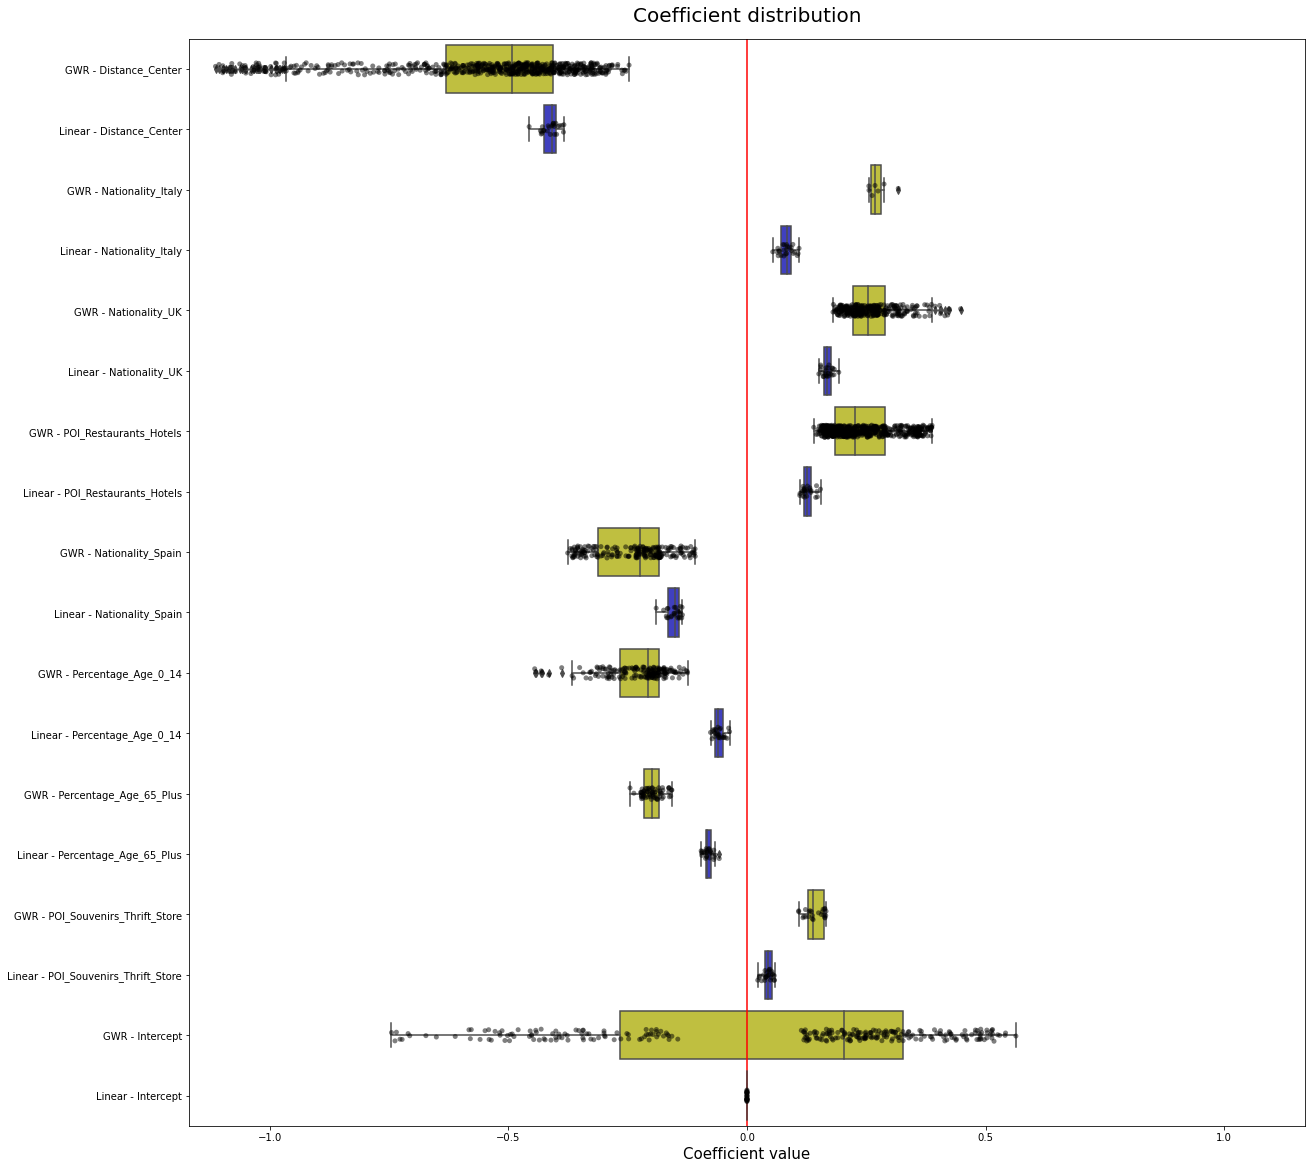

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(
    ax=ax,
    data=df_comparison,
    orient="h",
    color="k",
    alpha=0.5,
)

pal = {
    col: "yellow" if col.startswith("GWR") else "blue" for col in df_comparison.columns
}

sns.boxplot(
    ax=ax,
    data=df_comparison,
    orient="h",
    palette=pal,
    saturation=0.5,
)

plt.axvline(x=0, color="red")

ax.set_title("Coefficient distribution", fontsize=20, y=1.01)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "model_comparison.svg", format="svg")
    plt.savefig(DIR_GWR / "model_comparison.jpg")


plt.show()